In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomocupy.holo import G, GT
from holotomocupy.tomo import R, RT
from holotomocupy.magnification import M, MT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *

# Use managed memory
cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)
%matplotlib inline

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [ ]:
n = 512  # object size in each dimension
ntheta = 360  # number of angles (rotations)


theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6/1.5
energy = 17.05  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//8
show=True
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8
center = ne/2  # rotation axis

## Read data

In [ ]:
data = np.load(f'/data/vnikitin/data{n}.npy')
ref = np.load(f'/data/vnikitin/ref{n}.npy')
shifts = np.load(f'/data/vnikitin/shifts{n}.npy')
shifts_ref = np.load(f'/data/vnikitin/shifts_ref{n}.npy')
shifts_err = np.load(f'/data/vnikitin/shifts_err{n}.npy')

shifts_correct = shifts.copy()
shifts += shifts_err

### Correction with the reference

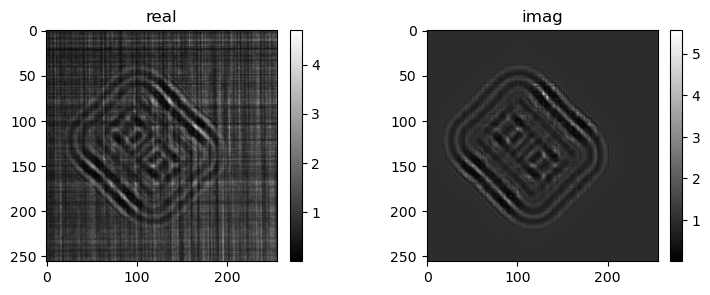

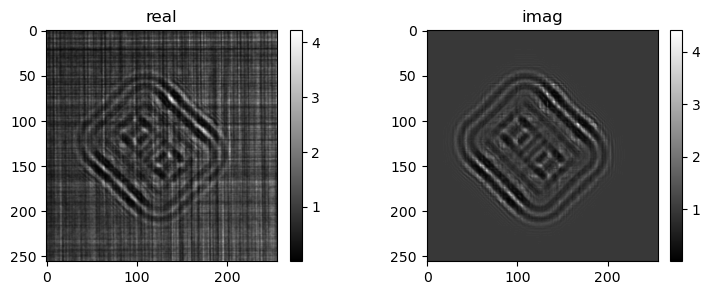

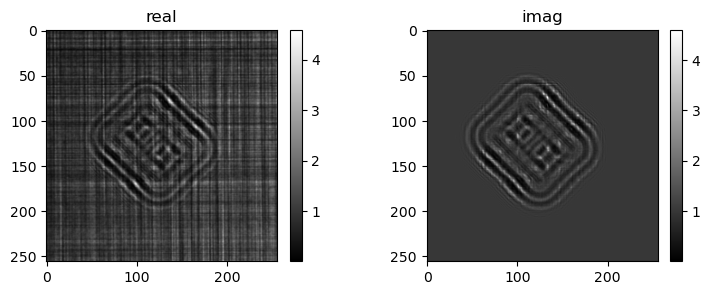

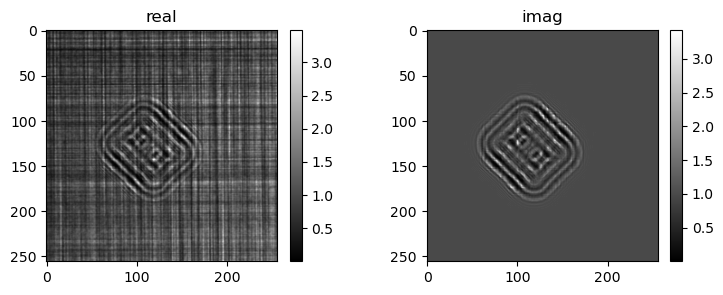

In [4]:
rdata = data/ref
for k in range(ndist):
    mshow_complex(data[0,k]+1j*rdata[0,k],show)

### Operators

In [5]:
def L2op(psi):
    data = cp.zeros([psi.shape[0], ndist, n, n], dtype='complex64')
    for i in range(ndist):
        psir = cp.array(psi[:,i])       
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LT2op(data):
    psi = cp.zeros([data.shape[0],ndist, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        datar = cp.array(data[:, j])
        psir = cp.pad(datar, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j],'symmetric')        
        psi[:,j] = psir
    return psi

def L1op(psi):
    data = cp.zeros([1, ndist, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(ndist):
        psir = cp.array(psi)       
        psir = G(psir, wavelength, voxelsize, distances2[i],'symmetric')
        data[:, i] = psir
    return data#further broadcasting to ntheta

def LT1op(data):
    psi = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        datar = cp.array(data[:, j])
        psir = datar
        psir = GT(psir, wavelength, voxelsize, distances2[j],'symmetric')        
        psi += psir
    return psi


def S2op(psi,shifts):
    data = cp.zeros([ntheta, ndist, ne, ne], dtype='complex64')
    psi = cp.array(psi)
    for j in range(ndist):
        psir = psi.copy()
        shiftsr = cp.array(shifts[:, j])#/norm_magnifications[j])
        psir = S(psir, shiftsr,'symmetric')
        data[:,j] = psir
    return data

def ST2op(data,shifts):
    psi = cp.zeros([ntheta, ne, ne], dtype='complex64')

    for j in range(ndist):
        datar = cp.array(data[:,j])
        shiftsr = cp.array(shifts[:, j])#/norm_magnifications[j])                
        psi += ST(datar,shiftsr,'symmetric')
    return psi

def S1op(psi):
    data = cp.zeros([1, ndist, n+2*pad, n+2*pad], dtype='complex64')
    psi = cp.array(psi)
    for i in range(ndist):
        psir = psi.copy()
        shiftsr = cp.array(shifts_ref[:, i])
        psir = S(psir, shiftsr,'symmetric')        
        data[:,i] = psir
    return data

def ST1op(data):
    psi = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(ndist):
        datar = cp.array(data[:,j])
        shiftsr = cp.array(shifts_ref[:, j])        
        psi += ST(datar,shiftsr,'symmetric')
    return psi

def Mop(psi):
    res = cp.zeros([ntheta, ndist, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(ndist):
        res[:,i] = M(psi[:,i], norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                        
    return res

def MTop(psi):
    res = cp.zeros([ntheta, ndist, ne, ne], dtype='complex64')
    for i in range(ndist):        
        res[:,i] = MT(psi[:,i], norm_magnifications[i]*ne/(n+2*pad), ne)        
    return res

def Rop(u):
    res = R(u,theta,center)
    return res.swapaxes(0,1)    

def RTop(data):
    res = RT(data.swapaxes(0,1),theta,center)
    return res    

# adjoint tests
arr1 = cp.random.random([1,n+2*pad,n+2*pad]).astype('complex64')
# shifts_ref = cp.random.random([1,ndist,2]).astype('float32')
arr2 = S1op(arr1)
arr3 = ST1op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = cp.random.random([1,n+2*pad,n+2*pad]).astype('complex64')
arr2 = L1op(arr1)
arr3 = LT1op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = cp.random.random([ntheta,ne,ne]).astype('complex64')
shifts_test = cp.random.random([ntheta,ndist,2]).astype('float32')
arr2 = S2op(arr1,shifts_test)# note magnification needed
arr3 = ST2op(arr2,shifts_test)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = cp.random.random([ntheta,ndist,ne,ne]).astype('complex64')
arr2 = Mop(arr1)
arr3 = MTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = cp.random.random([ntheta,ndist,n+2*pad,n+2*pad]).astype('complex64')
arr2 = L2op(arr1)
arr3 = LT2op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = cp.random.random([ne,ne,ne]).astype('complex64')
arr2 = Rop(arr1)
arr3 = RTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')


(136235.03125+0j)==
(136235.03125+0j)
(136835.09375-0.0017465967684984207j)==
(136835.09375+1.3689107163372682e-06j)
(60952760-0.0005684944917447865j)==
(60952764+8.6516172359552e-07j)
(24576856-3.338226318359375j)==
(24576858-1.1071088010794483e-06j)
(15727863-0.14647483825683594j)==
(15727864+2.6575022275210358e-05j)
(32483290-3.8953633308410645j)==
(32483292-9.955567747965688e-08j)


### Scale images and shift them based on random shifts

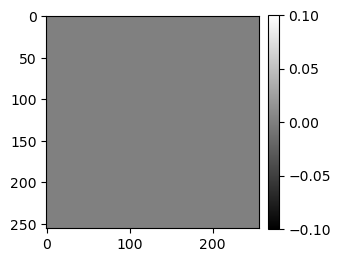

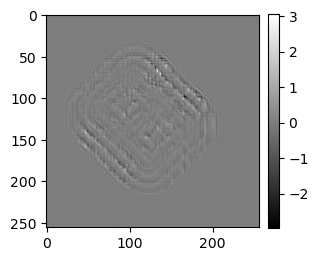

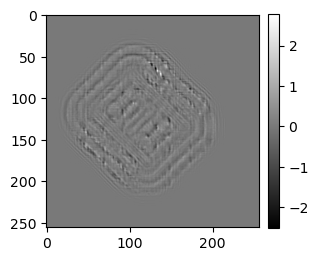

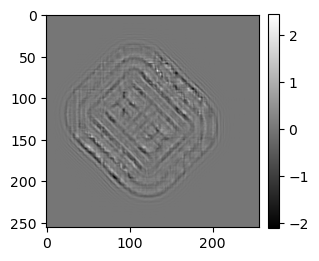

In [6]:
rdata_scaled = cp.array(rdata)
shifts=cp.array(shifts)
for k in range(ndist):
    r = M(rdata_scaled[:,k].astype('complex64'),1/norm_magnifications[k])
    rdata_scaled[:,k] = ST(r,shifts[:,k],'symmetric').real

for k in range(ndist):
    mshow(rdata_scaled[0,0]-rdata_scaled[0,k],show)

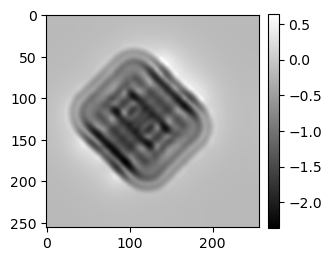

In [ ]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = np.exp(1j*multiPaganin(rdata_scaled, distances_pag, wavelength, voxelsize, 100, 1.2e-2))
mshow(np.angle(recMultiPaganin[0]),show)

### initial guess for the object

0) gamma=0.5, err=1.90594e+06


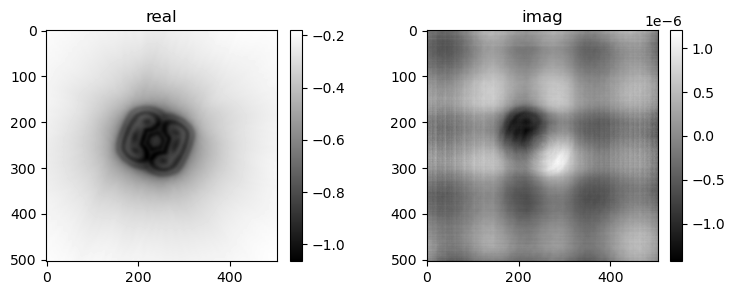

4) gamma=0.5, err=3.48968e+05
8) gamma=0.5, err=1.59890e+05
12) gamma=0.5, err=9.50399e+04
16) gamma=0.5, err=7.85415e+04
20) gamma=0.5, err=6.78939e+04
24) gamma=0.5, err=6.30716e+04
28) gamma=0.5, err=6.11363e+04
32) gamma=0.5, err=6.05497e+04


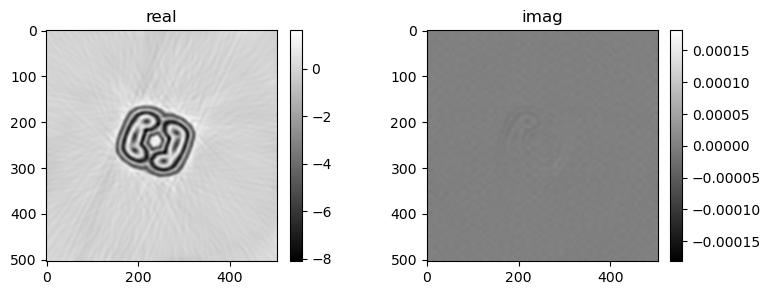

36) gamma=0.5, err=6.02316e+04
40) gamma=0.5, err=6.00726e+04
44) gamma=0.5, err=5.99650e+04
48) gamma=0.5, err=5.99022e+04
52) gamma=0.5, err=5.98523e+04
56) gamma=0.5, err=5.98067e+04
60) gamma=0.5, err=5.97457e+04
64) gamma=0.5, err=5.97047e+04


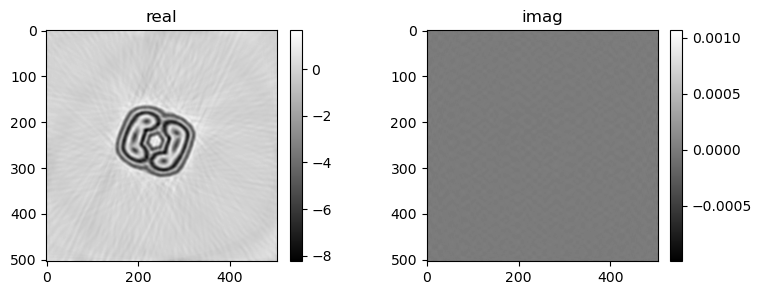

68) gamma=0.5, err=5.96601e+04


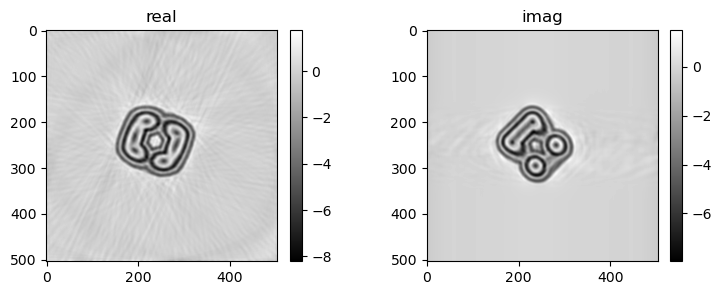

In [8]:
from holotomocupy.proc import dai_yuan, linear
def cg_tomo(data, init, pars):
    def minf(u):
        res = np.linalg.norm(Rop(u)-data)**2
        return res
    u = init.copy()
    for i in range(pars['niter']):
        fu = Rop(u)
        grad = 2*RTop(fu-data)#/np.float32(ne*ntheta)
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad
        gamma = 0.5
        u = linear(u,d,1,gamma)
        if i % pars['err_step'] == 0:
            err = minf(u)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_complex(u[ne//2],show)            
    return u


u = cp.zeros([ne,ne,ne],dtype='complex64')
data_tomo = cp.pad(cp.angle(recMultiPaganin),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

pars = {'niter': 70, 'err_step': 4, 'vis_step': 32}
u = cg_tomo(data_tomo, u, pars)   
rec_init = u
mshow_complex(rec_init[ne//2]+1j*rec_init[:,ne//2],show)

# Fifth rule

##### $D T_c|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)$
##### $ D^2{T_c}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{c}))$

In [9]:
def DT(psi,x,dx):
    res = cp.zeros([ntheta,ndist,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(ndist):
        psir = psi.copy()#cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dxj = cp.array(dx[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1*dxj[:,0]+xi2*dxj[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -2*np.pi*1j*psir#[:, ne//2:-ne//2, ne//2:-ne//2]       
    return res

def D2T(psi,x,dx1,dx2):
    res = cp.zeros([ntheta,ndist,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(ndist):
        psir = psi.copy()#cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dx1j = cp.array(dx1[:,j,:,np.newaxis,np.newaxis])
        dx2j = cp.array(dx2[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1**2*dx1j[:,0]*dx2j[:,0]+ \
                xi1*xi2*(dx1j[:,0]*dx2j[:,1]+dx1j[:,1]*dx2j[:,0])+ \
                xi2**2*dx1j[:,1]*dx2j[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -4*np.pi**2*psir#[:,ne//2:-ne//2, ne//2:-ne//2]       
    return res


\begin{align*}
 & DV|_{(q_0,u_0,{x}_0)}(\Delta q, \Delta u,\Delta{x})=L_1(q_0)\cdot M_j(T_{e^{i R (u_0)}\cdot(iR({\Delta u}))}(z_0)+ DT_{{e^{iR(u_0)}}}|_{{{z}_0}}( \Delta {z}))+L_1(\Delta q)\cdot M_j(T_{{e^{iR(u_0)}}}({{z}_0}))
\end{align*}

\begin{align*}
 & D^2V|_{(q_0,u_0,{x}_0)}\big((\Delta q^{(1)}, \Delta u^{(1)},\Delta{x^{(1)}}),(\Delta q^{(2)}, \Delta u^{(2)},\Delta{x}{(2)})\big)=\\&L_1(q_0)\cdot M_j(T_{e^{i R (u_0)}\cdot(-\frac{1}{2}(R({\Delta u^{(1)}})R({\Delta u^{(2)}})))}({{z}_0})+DT_{e^{i R (u_0)}\cdot\big(iR({\Delta u^{(1)}})\big)}|_{{{z}_0}}( \Delta {z}^{(2)})+DT_{e^{i R (u_0)}\cdot\big(iR({\Delta u^{(2)}})\big)}|_{{{z}_0}}( \Delta {z}^{(1)})+\frac{1}{2}\left(D^2{T_{e^{iR(u_0)}}}(\Delta z^{(1)},\Delta z^{(2)})\right))+\\&L_1(\Delta q^{(1)})\cdot M_j(T_{e^{i R (u_0)}\cdot(iR({\Delta u^{(2)}}))}+ DT_{{e^{iR(u_0)}}}|_{{{z}_0}}( \Delta {z}^{(2)}))+L_1(\Delta q^{(2)})\cdot M_j(T_{e^{i R (u_0)}\cdot(iR({\Delta u^{(1)}}))}+ DT_{{e^{iR(u_0)}}}|_{{{z}_0}}( \Delta {z}^{(1)}))
\end{align*}

In [10]:
def DV(q,u,x,dq,du,dx,eRu):
    Lq = L1op(q)
    Ldq = L1op(dq)    
    Rdu = Rop(du)    
    t1 = S2op(eRu*(1j*Rdu),x)+DT(eRu,x,dx)    
    t2 = S2op(eRu,x)
    return Lq*Mop(t1)+Ldq*Mop(t2)

def D2V(q,u,x,dq1,du1,dx1,dq2,du2,dx2,eRu):
    Lq = L1op(q)
    Ldq1 = L1op(dq1)    
    Ldq2 = L1op(dq2)    
    Rdu1 = Rop(du1)
    Rdu2 = Rop(du2)

    t1 = S2op(-0.5*eRu*Rdu1*Rdu2,x)+DT(eRu*1j*Rdu1,x,dx2)+DT(eRu*1j*Rdu2,x,dx1)+0.5*D2T(eRu,x,dx1,dx2)
    t2 = S2op(eRu*1j*Rdu2,x)+DT(eRu,x,dx2)
    t3 = S2op(eRu*1j*Rdu1,x)+DT(eRu,x,dx1)
    t1 = Lq*Mop(t1)
    t2 = Ldq1*Mop(t2)
    t3 = Ldq2*Mop(t3)
    return t1+t2+t3

\begin{equation*}
     \nabla_{q} H|_{(q_0,u_0,{x}_0)}= L_1^*\left(\overline{M_jS_{{x}_{0}}(e^{iRu})}\cdot \nabla F|_{V(q_0,u_0,{x}_0)}\right)
\end{equation*}

\begin{equation*}
  \nabla_{u} H|_{(q_0,u_0,{x}_0)}=-iR^*(\overline{e^{iRu_0}}S_{{x}_{0}}^*M_j^*\left(\overline{L_1(q_0)}\cdot \nabla F|_{V(q_0,u_0,{x}_0)}\right))
\end{equation*}

\begin{equation*}
\begin{aligned}
  \nabla_{{x}} H|_{(q_0,u_0,{x}_0)}=-2\pi \mathsf{Im} \Big(\big( &\Big\langle (\nabla F|_{V(q_0,u_0,{x}_0)}), L_1(q_0)\cdot  M_j(C(\mathcal{F}^{-1}(\xi_1 e^{-2\pi i x_{0}\cdot {\xi}}\widehat{e^{iRu}})))\Big\rangle,\\&\Big\langle (\nabla F|_{V(q_0,c_0,{x}_0)}),L_1(q_0)\cdot M_j(C(\mathcal{F}^{-1}(\xi_2 e^{-2\pi i x_{0}\cdot {\xi}}\widehat{e^{iRu}}))) \Big\rangle\big)\Big).
\end{aligned}
\end{equation*}
##### $$\tilde{L} = L_{2,j}(L_{1,j}(q)\cdot M_j(S_{{x}_{j,k}}(e^{iR_k(u)})))$$
##### $$\nabla F=2 \left(L^*_2\left( (L_2(\tilde{L}))-\tilde D\right)\right), \text{where } \tilde D = D \frac{(L_2(\tilde{L}))}{|L_2(\tilde{L})|}$$

   

In [11]:
def gradientq(q,u,x,gradF,eRu):
    t1 = np.conj(Mop(S2op(eRu,x)))*gradF
    return np.sum(LT1op(t1),axis=0)[np.newaxis]

def gradientu(q,u,x,gradF,eRu):
    Lq = L1op(q)
    t1 = np.conj(eRu)*ST2op(MTop(np.conj(Lq)*gradF),x)    
    return -1j*RTop(t1)

def gradientx(q,u,x,gradF,eRu):
    Lq = L1op(q)
    
    gradx = cp.zeros([ntheta,ndist,2],dtype='float32')    
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)

    psir = cp.pad(eRu, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
    
    tksi = cp.zeros([ntheta,ndist,ne,ne],dtype='complex64')
    for j in range(ndist):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                    
        tksi[:,j] = cp.fft.ifft2(pp*xi1*cp.fft.fft2(psir))[:, ne//2:-ne//2, ne//2:-ne//2]  
    gradx[:,:,0] = -2*np.pi*imdot(gradF,Lq*Mop(tksi),axis=(2,3))
    
    for j in range(ndist):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                    
        tksi[:,j] = cp.fft.ifft2(pp*xi2*cp.fft.fft2(psir))[:, ne//2:-ne//2, ne//2:-ne//2]      
    gradx[:,:,1] = -2*np.pi*imdot(gradF,Lq*Mop(tksi),axis=(2,3))    
    
    return gradx

def gradientF(vars,d):
    (q,u,x,eRu) = (vars['prb'], vars['u'], vars['shift'], vars['psi'])
    L2psi = L2op(L1op(q)*Mop(S2op(eRu,x)))
    td = d*(L2psi/np.abs(L2psi))
    res = 2*LT2op(L2psi - td)
    return res

def gradients(vars,gradF):    
    (q,u,x,eRu) = (vars['prb'], vars['u'], vars['shift'], vars['psi'])
    grads = {}
    grads['prb'] =rhoq*gradientq(q,u,x,gradF,eRu)
    grads['u'] = rhou*gradientu(q,u,x,gradF,eRu)
    grads['shift'] = rhox*gradientx(q,u,x,gradF,eRu)
    return grads

##### $$\frac{1}{2}\mathcal{H}^F|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L_2(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L_2(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L_2(z)))\right\rangle.$$
##### $$l_0=L_2(x_0)/|L_2(x_0)|$$
##### $$d_0=d/|L_2(x_0)|$$


In [12]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = L2op(hpsi)        
    Lpsi1 = L2op(hpsi1)
    Lpsi2 = L2op(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))    
    return 2*(v1+v2)

\begin{equation*}\begin{aligned}
&\mathcal{H}^H|_{ (q_0,u_0,{x}_0)}\Big((\Delta q^{(1)},\Delta u^{(1)},\Delta {x}^{(1)}),(\Delta q^{(2)},\Delta u^{(2)},\Delta {x}^{(2)})\Big)=\\&\Big\langle \nabla F|_{V(q_0,u_0,{x}_0)}, D^2V|_{(q_0,u_0,{x}_0)}\Big((\Delta q^{(1)},\Delta u^{(1)},\Delta {x}^{(1)}),(\Delta q^{(2)},\Delta u^{(2)},\Delta {x}^{(2)})\Big)\Big\rangle +\\&\mathcal{H}^F|_{V(q_0,u_0,{x}_0)}\Big(DV|_{(q_0,u_0,{x}_0)}(\Delta q^{(1)},\Delta u^{(1)},\Delta {x}^{(1)}),DV|_{(q_0,u_0,{x}_0)}(\Delta q^{(2)},\Delta u^{(2)},\Delta {x}^{(2)})\Big).
\end{aligned}
\end{equation*}

In [ ]:
def calc_beta(vars,grads,etas,data,gradF):
    (q,u,x,eRu) = (vars['prb'], vars['u'], vars['shift'], vars['psi'])
    (dq1,du1,dx1) = (grads['prb']*rhoq, grads['u']*rhou, grads['shift']*rhox)
    (dq2,du2,dx2) = (etas['prb']*rhoq, etas['u']*rhoq, etas['shift']*rhox)
    L1psi = L1op(q)*Mop(S2op(eRu,x))
    
    dv1 = DV(q,u,x,dq1,du1,dx1,eRu)
    d2v1 = D2V(q,u,x,dq1,du1,dx1,dq2,du2,dx2,eRu)
    dv2 = DV(q,u,x,dq2,du2,dx2,eRu)    
    d2v2 = D2V(q,u,x,dq2,du2,dx2,dq2,du2,dx2,eRu) 
    
    top = redot(gradF,d2v1)+hessianF(L1psi,dv1,dv2,data) 
    bottom = redot(gradF,d2v2)+hessianF(L1psi,dv2,dv2,data) 
    return top/bottom

def calc_alpha(vars,grads,etas,data,gradF):    
    (q,u,x,eRu) = (vars['prb'], vars['u'], vars['shift'], vars['psi'])
    (dq1,du1,dx1) = (grads['prb'], grads['u'], grads['shift'])
    (dq2,du2,dx2) = (etas['prb'], etas['u'], etas['shift'])
    
    L1psi = L1op(q)*Mop(S2op(eRu,x))        
    top = -redot(dq1,dq2)-redot(du1,du2)-redot(dx1,dx2)    

    (dq2,du2,dx2) = (etas['prb']*rhoq, etas['u']*rhou, etas['shift']*rhox)    
    d2v2 = D2V(q,u,x,dq2,du2,dx2,dq2,du2,dx2,eRu) 
    dv2 = DV(q,u,x,dq2,du2,dx2,eRu)
    bottom = redot(gradF,d2v2)+hessianF(L1psi,dv2,dv2,data)         

    return top/bottom, top, bottom

In [14]:
def minf(q,u,x,data):
    eRu = np.exp(1j*Rop(u))
    L2psi = L2op(L1op(q)*Mop(S2op(eRu,x)))
    f = np.linalg.norm(np.abs(L2psi)-data)**2
    return f
    
def plot_debug2(vars,etas,top,bottom,alpha,data):
    (q,u,x) = (vars['prb'], vars['u'], vars['shift'])
    (dq2,du2,dx2) = (etas['prb'], etas['u'], etas['shift'])
    npp = 9
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        ut = u+(alpha*k/(npp-1))*du2*rhou
        qt = q+(alpha*k/(npp-1))*dq2*rhoq
        xt = x+(alpha*k/(npp-1))*dx2*rhox
        errt[k] = minf(qt,ut,xt,data)    

    t = alpha*(cp.arange(2*npp))/(npp-1)
    errt2 = minf(q,u,x,data)-top*t+0.5*bottom*t**2
    
    plt.plot((alpha*cp.arange(2*npp)/(npp-1)).get(),errt.get(),'.')
    plt.plot((alpha*cp.arange(2*npp)/(npp-1)).get(),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    for k in range(ndist):        
        axs[0].plot(shifts_correct[:,k,0]-(shifts[:,k,0].get().flatten()),'.')
        axs[1].plot(shifts_correct[:,k,1]-(shifts[:,k,1].get().flatten()),'.')
    plt.show()

def vis_debug(vars,i):
    mshow_complex(vars['u'][ne//2,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2].real+1j*
                  vars['u'][ne//2-n//2:ne//2+n//2,ne//2,ne//2-n//2:ne//2+n//2].real,show)
    mshow_polar(vars['prb'][0],show)
    # dxchange.write_tiff(np.angle(vars['psi'][0]).get(),f'{path}/crec_code_angle{flg}/{i:03}',overwrite=True)
    # dxchange.write_tiff(np.angle(vars['prb'][0]).get(),f'{path}/crec_prb_angle{flg}/{i:03}',overwrite=True)
    # dxchange.write_tiff(np.abs(vars['psi'][0]).get(),f'{path}/crec_code_abs{flg}/{i:03}',overwrite=True)
    # dxchange.write_tiff(np.abs(vars['prb'][0]).get(),f'{path}/crec_prb_abs{flg}/{i:03}',overwrite=True)
    
def err_debug(vars, grads, data):  
    (q,u,x) = (vars['prb'], vars['u'], vars['shift'])  
    (dq,du,dx) = (grads['prb'], grads['u'], grads['shift'])  
    err = minf(q,u,x,data)        
    print(f'gradient norms (prb, u, shift): {np.linalg.norm(dq):.2f}, {np.linalg.norm(du):.2f}, {np.linalg.norm(dx):.2f}')                        
    return err

## Main CG loop (fifth rule)

In [15]:
def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2
        return f

    ref = np.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = L2op(L1op(prb))#[:,:,pad:-pad,pad:-pad]
        fprb0 = fprb0-ref*np.exp(1j*np.angle(fprb0))
        gradprb = 0.5*LT1op(LT2op(fprb0))

        if i == 0:
            dprb = -gradprb
        else:
            dprb = dai_yuan(dprb,gradprb,gradprb0)              
        gradprb0 = gradprb

        # line search
        gammaprb = 0.5
        prb = prb + gammaprb*dprb

        if i % pars['err_step'] == 0:
            fprb0 = L2op(L1op(prb))#[:,:,pad:-pad,pad:-pad]
            err = minf(fprb0)
            print(f'{i}) {gammaprb=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(prb[0])

    return prb


rec_prb_init= cp.ones([1, n+2*pad, n+2*pad], dtype='complex64')
ref = cp.array(ref)#.copy()
pars = {'niter': 8, 'err_step': 1, 'vis_step': 16, 'gammaprb': 0.5}
rec_prb_init = cg_holo(ref, rec_prb_init, pars)

0) gammaprb=0.5, err=2.05200e-04
1) gammaprb=0.5, err=1.12708e-06
2) gammaprb=0.5, err=1.10551e-06
3) gammaprb=0.5, err=1.11128e-06
4) gammaprb=0.5, err=1.11209e-06
5) gammaprb=0.5, err=1.11841e-06
6) gammaprb=0.5, err=1.11547e-06
7) gammaprb=0.5, err=1.12703e-06


In [ ]:
def cg_holo(data, vars, pars):
    data = np.sqrt(data)    
    erra = np.zeros(pars['niter'])
        
    for i in range(pars['niter']):      
        vars['psi'] = np.exp(1j*Rop(vars['u']))
        gradF = gradientF(vars,data)
        grads = gradients(vars,gradF)
        if i==0:
            etas = {}
            etas['u'] = -grads['u']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, gradF)
            etas['u'] = -grads['u'] + beta*etas['u']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, gradF) 
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,top,bottom,alpha,data)
        vars['u'] += rhou*alpha*etas['u']
        vars['prb'] += rhoq*alpha*etas['prb']
        vars['shift'] += rhox*alpha*etas['shift']
        
        if i % pars['err_step'] == 0 and pars['err_step'] != -1:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}',flush=True)
            erra[i] = err
        
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, i)
            plot_debug3(vars['shift'])     
    return vars,erra

rhoq = 0.05
rhou = 1
rhox = 0.2

vars={}
vars['u'] = rec_init.copy()#cp.load('data/u.npy')
vars['prb'] = rec_prb_init.copy()#cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')#
# vars['prb'] = cp.load('data/prb.npy')#cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')#cp.array(np.load('data/prb.npy'))#
vars['shift'] = cp.array(shifts)
data = cp.array(data)

pars = {'niter': 1, 'err_step': 2, 'vis_step': -1}
%load_ext line_profiler
%lprun -f gradientu cg_holo(data, vars, pars)   

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
gradient norms (prb, u, shift): 183.97, 176.49, 433.01
0) alpha=0.29698, err=1.03138e+05


Timer unit: 1e-09 s

Total time: 0.387442 s
File: /tmp/ipykernel_3721173/3990536572.py
Function: gradientu at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def gradientu(q,u,x,gradF,eRu):
     6         1    5557136.0    6e+06      1.4      Lq = L1op(q)
     7         1  240559851.0    2e+08     62.1      t1 = np.conj(eRu)*ST2op(MTop(np.conj(Lq)*gradF),x)    
     8         1  141325305.0    1e+08     36.5      return -1j*RTop(t1)

: 